In [11]:
import torch
import torch.nn as nn

# 前置知识

- MOE层替换的是FFN，用于减少参数，提高训练&推理速度

# 基础MOE
![image.png](./images/moe_base.png)

In [16]:
class BasicExpert(nn.Module):
    # 一个 Expert 可以是一个最简单的， linear 层即可
    # 也可以是 MLP 层
    # 也可以是 更复杂的 MLP 层（active function 设置为 swiglu）
    def __init__(self, feature_in, feature_out):
        super().__init__()
        self.linear = nn.Linear(feature_in, feature_out)

    def forward(self, x):
        return self.linear(x)

In [17]:
class BasicMOE(nn.Module):
    def __init__(self, feature_in, feature_out, expert_number):
        super().__init__()
        self.experts = nn.ModuleList(
            [
                BasicExpert(feature_in, feature_out) for _ in range(expert_number)
            ]
        )
        # gate 决定了每一个 expert 的权重
        self.gate = nn.Linear(feature_in, expert_number)
    
    def forward(self, x):
        # x 的 shape 是 （batch, feature_in)
        expert_weight = self.gate(x)  # shape 是 (batch, expert_number)
        expert_out_list = [
            expert(x).unsqueeze(1) for expert in self.experts
        ]  # 里面每一个元素的 shape 是： (batch, 1, feature_out) 

        # concat 起来 (batch, expert_number, feature_out)
        expert_output = torch.cat(tensors=expert_out_list, dim=1)

        # print(expert_output.size())

        expert_weight = expert_weight.unsqueeze(1) # (batch, 1, expert_nuber)

        # expert_weight * expert_out_list
        output = expert_weight @ expert_output  # (batch, 1, feature_out)
        
        return output.squeeze()  # (batch, 1, feature_out) -> (batch, feature_out)


def test_basic_moe():
    x = torch.rand(2, 5) # shape (batch, feature_in)

    basic_moe = BasicMOE(x.shape[1], 3, 3)
    out = basic_moe(x) # shape 是 (batch, feature_out)
    print(out)


test_basic_moe()

tensor([[ 0.1430,  0.0529, -0.1347],
        [ 0.0381, -0.3492,  0.0297]], grad_fn=<SqueezeBackward0>)


# SparseMoE （大模型训练使用）

- 来自switch transformers
- 和 基础MOE 区别是，Sparse MOE 选择 topK 个专家，然后对这 topK 个专家的输出进行加权求和，并且把输入样本变成了大模型中真实的输入 Shape: (batch, seq_len, hidden_dim)

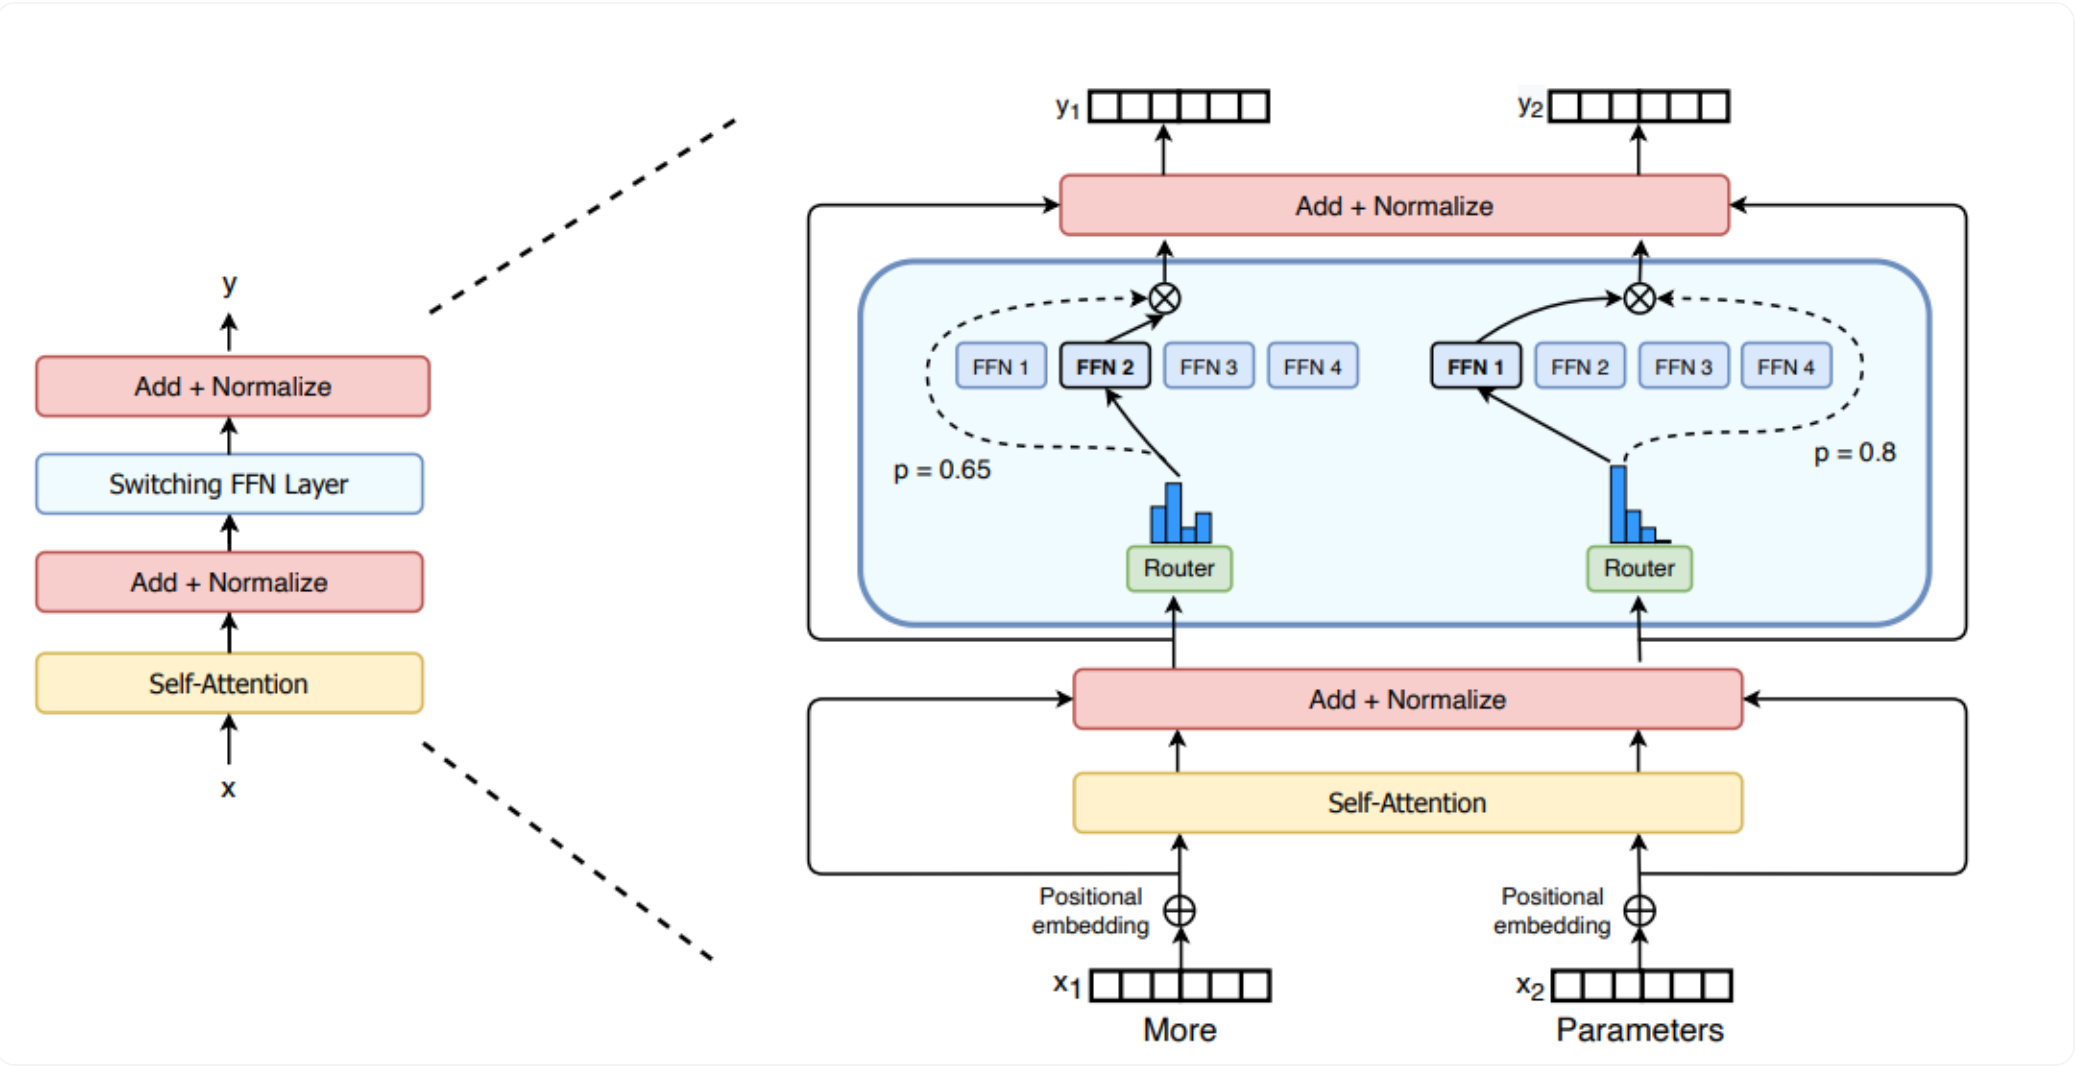

In [ ]:
# 主要参考自 mistral MOE 的实现
import torch.nn.functional as F

class MOERouter(nn.Module):
    def __init__(self, hidden_dim, expert_number, top_k):
        super().__init__()
        self.gate = nn.Linear(hidden_dim, expert_number)
        self.expert_number = expert_number
        self.top_k = top_k

    def forward(self, hidden_states):
        # 计算路由logits
        # hidden_states shape is (b * s, hidden_dim)
        # router_logits shape is (b * s, expert_number)
        router_logits = self.gate(hidden_states)

        # 计算专家经过softmax之后的概率
        routing_probs = F.softmax(router_logits, dim=-1, dtype=torch.float)

        # 计算topk的专家的输出
        '''
        torch.topk 返回一个包含两个张量的元组 (values, indices)：
            - values: 包含找到的 k 个最大值的张量。
            - indices: 包含这些值在原张量相应维度中的索引位置的张量。
        注，返回的是从大到小的 top_k 的值和对应的索引
        '''
        # shape都是 (b * s, top_k)
        router_weights, selected_experts = torch.topk(
            routing_probs, self.top_k, dim=-1
        )  

        # 专家权重归一化
        router_weights = router_weights / \
            router_weights.sum(dim=-1, keepdim=True)
        router_weights = router_weights.to(hidden_states.dtype)


        '''
        F.one_hot 是 PyTorch 中 torch.nn.functional 模块提供的一个函数，用于将标签索引转换为独热编码（one-hot encoding）向量
        torch.nn.functional.one_hot(tensor, num_classes=-1)
        参数    
            - tensor：输入张量，包含需要转换为独热编码的类别索引。这些索引必须是整数类型，且值应在 0 到 num_classes-1 之间。
            - num_classes：类别总数，即独热编码向量的维度。如果设为 -1（默认值），函数会自动将其设置为输入张量中的最大值加 1。

        返回值
            函数返回一个新的张量，其中每个输入索引被转换为一个独热编码向量。返回的张量会比输入张量多一个维度（最后一个），这个新维度的大小等于 num_classes。
        '''
        # 生成专家掩码
        # shape是 (b * s, top_k, expert_number)
        expert_mask = F.one_hot(
            selected_experts,
            num_classes=self.expert_number
        )  
        # (expert_number, top_k, b * s)
        expert_mask = expert_mask.permute(2, 1, 0)

        return router_logits, router_weights, selected_experts, expert_mask


class MOEConfig:
    def __init__(
        self,
        hidden_dim,
        expert_number,
        top_k,
        shared_experts_number=2,
    ):
        self.hidden_dim = hidden_dim
        self.expert_number = expert_number
        self.top_k = top_k
        self.shared_experts_number = shared_experts_number


class SparseMOE(nn.Module):
    # 稀疏 MOE 模型，这里每一个 token 都会过 topk 个专家，得到对应token 的 hidden_embeddings
    def __init__(self, config):
        super().__init__()

        self.hidden_dim = config.hidden_dim

        self.expert_number = config.expert_number
        self.top_k = config.top_k

        self.experts = nn.ModuleList(
            [
                BasicExpert(self.hidden_dim, self.hidden_dim) for _ in range(self.expert_number)
            ]
        )

        self.router = MOERouter(
            self.hidden_dim, self.expert_number, self.top_k)

    def forward(self, x):
        # x shape is (batch_size, seq_len, hidden_dim)
        batch_size, seq_len, hidden_dim = x.size()

        # 合并前两个维度，因为不是 Sample 维度了，而是 token 维度
        hidden_states = x.view(-1, hidden_dim)  # shape is(b * s, hidden_dim)

        router_logits, router_weights, selected_experts_indices, expert_mask = self.router(
            hidden_states)
        # router_logits shape is (b * s, expert_number)
        # router_weights shape is (b * s, top_k)
        # selected_experts_indices shape 是 (b * s, top_k)
        # expert_mask shape 是 (expert_number, top_k, b * s)

        final_hidden_states = torch.zeros(
            size=(batch_size * seq_len, hidden_dim),
            dtype=hidden_states.dtype,
            device=hidden_states.device
        )

        for expert_idx in range(self.expert_number):
            expert_layer = self.experts[expert_idx]
            # expert_mask[expert_idx] shape 是 (top_k, b * s)
            idx, top_x = torch.where(expert_mask[expert_idx])
            # idx 和 top_x 都是一维 tensor
            # idx 的值是 0 或 1, 表示这个 token 是作为当前专家的 top1 还是 top2
            # top_x 的值是 token 在 batch*seq_len 中的位置索引
            # 例如对于 batch_size=2, seq_len=4 的输入:
            # top_x 的值范围是 0-7, 表示在展平后的 8 个 token 中的位置
            # idx 的值是 0/1, 表示这个 token 把当前专家作为其 top1/top2 专家

            # hidden_states 的 shape 是 (b * s, hidden_dim)
            # 需要取到 top_x 对应的 hidden_states
            current_state = hidden_states.unsqueeze(
                0
            )[:, top_x, :].reshape(-1, hidden_dim)  # （selected_token_number, hidden_dim）

            # router_weight 的 shape 是 (b * s, top_k)
            current_hidden_states = expert_layer(
                current_state
            ) * router_weights[top_x, idx].unsqueeze(-1)  # （selected_token_number, 1） 这里有广播

            # 把当前专家的输出加到 final_hidden_states 中
            # 方式1 的写法性能更好，并且方式1容易出现
            final_hidden_states.index_add_(
                0, top_x, current_hidden_states.to(hidden_states.dtype))
            # 方式2
            # final_hidden_states[top_x] += current_hidden_states.to(hidden_states.dtype)
            # 方式2 的写法性能更差，并且方式2容易出现错误，+= 操作在处理重复索引时需要多次读写内存，可能会导致竞争条件

        # 把 final_hidden_states 还原到原来的 shape
        final_hidden_states = final_hidden_states.reshape(
            batch_size, seq_len, hidden_dim)

        # shape 是 (b * s, expert_number)
        return final_hidden_states, router_logits


def test_token_level_moe():
    # x shape (batch_size, seq_len, hidden_dim)
    x = torch.rand(2, 4, 16)
    config = MOEConfig(16, 2, 2)
    token_level_moe = SparseMOE(config)
    out = token_level_moe(x)
    print(out[0].shape, out[1].shape)


test_token_level_moe() # torch.Size([2, 4, 16]) torch.Size([8, 2])

torch.Size([2, 4, 16]) torch.Size([8, 2])


# 参考
- https://bruceyuan.com/llms-zero-to-hero/the-way-of-moe-model-evolution.html